<a href="https://colab.research.google.com/github/roshelle-en/Edge-Detection-with-Mamba/blob/main/EDMB_ScratchImproved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("cuda available:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("cuda device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

cuda available: True
torch: 2.8.0+cu126
cuda device: Tesla T4


In [2]:
!pip install -q torch torchvision

In [3]:
!pip install -q tqdm opencv-python matplotlib pillow scipy

In [4]:
pip install -q git+https://github.com/Dao-AILab/causal-conv1d@v1.1.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 21.2 MB/s eta 0:00:00


High-resolution encoder (Eh)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HighResEncoder(nn.Module):
    """
    Exact match to paper's Eh: Two conv blocks with pool in between.
    Outputs: F1h (16ch, HxW), F2h (32ch, H/2xW/2).
    No BN, no upsample/refine—purely for location preservation.
    """
    def __init__(self, in_ch=3):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )  # 3->16, same res
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )  # 16->32, after pool (half res)

    def forward(self, x):
        # x: (B,3,H,W)
        f1 = self.conv1(x)      # (B,16,H,W)
        pooled = self.pool(f1)  # (B,16,H/2,W/2)
        f2 = self.conv2(pooled) # (B,32,H/2,W/2)
        return [f1, f2]  # List: F1h, F2h

# Quick test (run this in your notebook)
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = HighResEncoder(in_ch=3).to(device)
    x = torch.randn(2, 3, 320, 320).to(device)
    feats = model(x)
    print("F1h shape:", feats[0].shape)  # Should be [2,16,320,320]
    print("F2h shape:", feats[1].shape)  # Should be [2,32,160,160]
    print("Params:", sum(p.numel() for p in model.parameters()))  # ~10k, very light

F1h shape: torch.Size([2, 16, 320, 320])
F2h shape: torch.Size([2, 32, 160, 160])
Params: 5088


Global Mamba Encoder (Eg) and Fine-grained Mamba Encoder (Ef)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyVGGBlock(nn.Module):
    """Basic VGG-style block: Conv3x3 + ReLU, no BN for lightness."""
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class TinyVGGEncoder(nn.Module):
    """
    Lightweight VGG-like encoder mimicking Mamba stages.
    Outputs 3 scales: stage1 (/1 res, 64ch), stage2 (/2, 128ch), stage3 (/4, 256ch).
    Matches paper's 3-stage adoption (no stage4 for low-res waste).
    """
    def __init__(self, in_ch=3, base_ch=64):
        super().__init__()
        # Stage 1: Full res (mimic patch embed without downsample yet)
        self.stage1 = nn.Sequential(
            TinyVGGBlock(in_ch, base_ch),      # 3->64, /1
            TinyVGGBlock(base_ch, base_ch)     # 64->64, /1
        )
        # Stage 2: Downsample to /2
        self.stage2 = nn.Sequential(
            nn.MaxPool2d(2, 2),                # /2
            TinyVGGBlock(base_ch, base_ch*2),  # 64->128, /2
            TinyVGGBlock(base_ch*2, base_ch*2) # 128->128, /2
        )
        # Stage 3: Downsample to /4
        self.stage3 = nn.Sequential(
            nn.MaxPool2d(2, 2),                # /4 total
            TinyVGGBlock(base_ch*2, base_ch*4),# 128->256, /4
            TinyVGGBlock(base_ch*4, base_ch*4) # 256->256, /4
        )

    def forward(self, x):
        f1 = self.stage1(x)   # (B,64,H,W)
        f2_input = self.stage2[0](f1)  # pool to /2
        f2 = self.stage2[1:](f2_input) # convs
        f3_input = self.stage3[0](f2)  # pool to /4
        f3 = self.stage3[1:](f3_input) # convs
        return [f1, f2, f3]  # List: 3 scales

class GlobalLocalEncoder(nn.Module):
    """
    CNN alternative to Eg + Ef (fixed detach for grad flow).
    """
    def __init__(self, base_ch=64):
        super().__init__()
        self.global_enc = TinyVGGEncoder(in_ch=3, base_ch=base_ch)
        self.local_enc = TinyVGGEncoder(in_ch=3, base_ch=base_ch)

    def forward(self, x, training=True):
        B, _, H, W = x.shape
        # 1. Global features
        global_feats = self.global_enc(x)

        # 2. Local patches
        h_mid, w_mid = H // 2, W // 2
        patches = [
            x[:, :, :h_mid, :w_mid],
            x[:, :, :h_mid, w_mid:],
            x[:, :, h_mid:, :w_mid],
            x[:, :, h_mid:, w_mid:]
        ]
        local_feats_per_patch = [self.local_enc(p) for p in patches]

        # 3. Training dropout: Pick one patch to keep grads
        drop_idx = None
        if training:
            drop_idx = torch.randperm(4)[0]  # 0-3; keep this, detach others

        # 4. Stitch: Detach dropped patches *before* cat (out-of-place)
        local_feats = []
        for lvl in range(3):
            patch_feats_lvl = []
            for j in range(4):
                pf = local_feats_per_patch[j][lvl]
                if training and j != drop_idx:
                    pf = pf.detach()  # Out-of-place: No grad flow to dropped
                patch_feats_lvl.append(pf)
            f00, f01, f10, f11 = patch_feats_lvl
            top = torch.cat([f00, f01], dim=3)
            bot = torch.cat([f10, f11], dim=3)
            merged = torch.cat([top, bot], dim=2)
            local_feats.append(merged)

        return global_feats, local_feats

# Quick test (run this in your notebook)
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = GlobalLocalEncoder(base_ch=64).to(device)
    x = torch.randn(2, 3, 320, 320).to(device)  # Even H/W for clean split
    global_feats, local_feats = model(x)
    for i, (g, l) in enumerate(zip(global_feats, local_feats)):
        print(f"Level {i+1}: global {g.shape}, local {l.shape}")  # e.g., [2,64,320,320], [2,64,320,320] etc.
    print("Total params:", sum(p.numel() for p in model.parameters()))  # ~1.5M, efficient

Level 1: global torch.Size([2, 64, 320, 320]), local torch.Size([2, 64, 320, 320])
Level 2: global torch.Size([2, 128, 160, 160]), local torch.Size([2, 128, 160, 160])
Level 3: global torch.Size([2, 256, 80, 80]), local torch.Size([2, 256, 80, 80])
Total params: 2290816


In [35]:
# High-resolution encoder (Eh)
model_Eh = HighResEncoder(in_ch=3).to(device)  # No base_ch—hardcoded inside

# Combined Global + Fine-grained encoder (Eg + Ef) - CNN alternative
model = GlobalLocalEncoder(base_ch=64).to(device)
print("Encoder fixed & re-instantiated.")

Encoder fixed & re-instantiated.


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GlobalLocalEncoder(base_ch=64).to(device)
model_Eh = HighResEncoder(in_ch=3).to(device)

x = torch.randn(2, 3, 320, 320).to(device)
with torch.no_grad():
    f_high = model_Eh(x)
    global_feats, local_feats = model(x)

print("Eh outputs:")
for i, f in enumerate(f_high):
    print(f"  F{i+1}h: {f.shape}")
print("\nGlobal feats:")
for i, g in enumerate(global_feats):
    print(f"  F{i+1}g: {g.shape}")
print("\nLocal feats:")
for i, l in enumerate(local_feats):
    print(f"  F{i+1}f: {l.shape}")

Eh outputs:
  F1h: torch.Size([2, 16, 320, 320])
  F2h: torch.Size([2, 32, 160, 160])

Global feats:
  F1g: torch.Size([2, 64, 320, 320])
  F2g: torch.Size([2, 128, 160, 160])
  F3g: torch.Size([2, 256, 80, 80])

Local feats:
  F1f: torch.Size([2, 64, 320, 320])
  F2f: torch.Size([2, 128, 160, 160])
  F3f: torch.Size([2, 256, 80, 80])


Learnable Gaussian Distribution Decoder

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LGDDecoder_Light(nn.Module):
    """
    Simplified Learnable Gaussian Distribution (LGD) decoder.
    Fuses high-res (Eh) and global (Eg/Ef) features.
    Outputs mu, sigma², and an auxiliary edge map.
    """
    def __init__(self, in_ch_high=16, in_ch_global=128, mid_ch=64):
        super().__init__()
        # 1️⃣ Fuse features from Eh and Eg/Ef
        self.fuse = nn.Sequential(
            nn.Conv2d(in_ch_high + in_ch_global, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True)
        )
        # 2️⃣ Output heads
        self.mu_head = nn.Conv2d(mid_ch, 1, kernel_size=1)      # mean
        self.var_head = nn.Sequential(                          # variance (>=0)
            nn.Conv2d(mid_ch, 1, kernel_size=1),
            nn.Softplus()
        )
        self.edge_head = nn.Conv2d(mid_ch, 1, kernel_size=1)    # auxiliary edge map

    def forward(self, f_high, f_global):
        # Upsample global feature to match high-res size
        f_global_up = F.interpolate(f_global, size=f_high.shape[-2:], mode='bilinear', align_corners=False)
        fused = torch.cat([f_high, f_global_up], dim=1)
        x = self.fuse(fused)
        mu = self.mu_head(x)
        sigma2 = self.var_head(x)
        edge_logits = self.edge_head(x)
        return mu, sigma2, edge_logits

# 🔍 Test with random features
device = "cuda" if torch.cuda.is_available() else "cpu"
decoder = LGDDecoder_Light(in_ch_high=16, in_ch_global=128, mid_ch=64).to(device)

# fake inputs from your encoders
f_high = torch.randn(1, 16, 320, 320).to(device)
f_global = torch.randn(1, 128, 80, 80).to(device)

mu, sigma2, edge_logits = decoder(f_high, f_global)
print("mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print("sigma2 min/max:", sigma2.min().item(), sigma2.max().item())

mu: torch.Size([1, 1, 320, 320]) sigma2: torch.Size([1, 1, 320, 320]) edge_logits: torch.Size([1, 1, 320, 320])
sigma2 min/max: 0.35759100317955017 2.4042513370513916


Loss Function

In [38]:
import torch
import torch.nn.functional as F

def elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1):
    """
    mu, sigma2 : model outputs, shape [B,1,H,W]
    y          : ground truth edges (0/1), same shape
    phi        : weight for KL term
    lambda_pos : positive class weight (for edge pixels)
    """
    # --- Sample from Gaussian N(mu, sigma2)
    eps = torch.randn_like(mu)
    p = mu + eps * torch.sqrt(sigma2 + 1e-6)  # reparam trick
    p = torch.sigmoid(p)  # edge probability 0-1

    # --- Weighted BCE
    pos = (y == 1).float()
    neg = (y == 0).float()
    total = y.numel()
    pos_count = pos.sum().clamp_min(1.0)
    neg_count = neg.sum().clamp_min(1.0)
    alpha = pos_count / total
    beta = lambda_pos * (neg_count / total)
    wce = -(alpha * (pos * torch.log(p + 1e-8)).sum() +
            beta * (neg * torch.log(1 - p + 1e-8)).sum()) / total

    # --- KL divergence  D_KL(N(μ,σ²) || N(0,1))
    kl = 0.5 * ((mu ** 2 + sigma2 - torch.log(sigma2 + 1e-8) - 1).sum()) / total

    elbo = wce + phi * kl
    return elbo, wce, kl

In [39]:
# Fake outputs and ground truth
mu = torch.randn(1, 1, 320, 320)
sigma2 = torch.abs(torch.randn(1, 1, 320, 320))  # positive
y = (torch.rand(1, 1, 320, 320) > 0.8).float()   # random binary mask

elbo, wce, kl = elbo_loss(mu, sigma2, y)
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

ELBO: 1.36577 | WCE: 0.65136 | KL: 0.71441


Checking with a fake batch

In [40]:
# End-to-end forward + ELBO test (use the models you built earlier)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# ensure these variables exist in your notebook:
# model_Eh, model_MIX, decoder (LGDDecoder_Light), and elbo_loss function

# Put models in train mode so gradients exist (we'll do a backward check)
model_Eh.train()
model_MIX.train()
decoder.train()

# Create a small fake batch
B = 2
x = torch.randn(B, 3, 320, 320).to(device)
# fake ground truth edges: sparse random edges
y = (torch.rand(B, 1, 320, 320) > 0.95).float().to(device)

# Forward: encoders
f_high = model_Eh(x)            # list [f1, f2_refined]  (both 320x320)
g_global, g_local = model_MIX(x)  # g_local is list of multi-scale fused local features

# Choose which global feature to feed to decoder:
# we used level3 (deepest) earlier: g_local[-1] or g_global[-1]
f_global_for_decoder = g_local[-1]  # shape [B, 128, 80, 80]

# Use f_high[1] (refined high-res) as the high-res input (same as earlier tests)
f_high_for_decoder = f_high[1]     # shape [B, 16, 320, 320]

# Decoder forward
mu, sigma2, edge_logits = decoder(f_high_for_decoder, f_global_for_decoder)

# Compute ELBO (phi=1.0)
elbo, wce, kl = elbo_loss(mu, sigma2, y, phi=1.0, lambda_pos=1.1)

print("Shapes:")
print(" x:", x.shape)
print(" f_high:", [tuple(t.shape) for t in f_high])
print(" g_local:", [tuple(t.shape) for t in g_local])
print(" mu:", mu.shape, "sigma2:", sigma2.shape, "edge_logits:", edge_logits.shape)
print()
print(f"ELBO: {elbo.item():.5f} | WCE: {wce.item():.5f} | KL: {kl.item():.5f}")

# Backward check: gradients should flow to decoder parameters (not to frozen global encoder if frozen)
elbo.backward()
print()
print("Gradients (sample):")
for name, p in list(decoder.named_parameters())[:6]:
    if p.grad is None:
        print(f"  {name}: grad None")
    else:
        print(f"  {name}: grad mean {p.grad.mean().item():.6e}, std {p.grad.std().item():.6e}")
# also check one param in model_Eh to see grad exists
for name, p in model_Eh.named_parameters():
    print(f"Eh param {name}: requires_grad={p.requires_grad}, grad is {'present' if p.grad is not None else 'None'}")
    break

RuntimeError: Given groups=1, weight of size [64, 144, 3, 3], expected input[2, 160, 160, 160] to have 144 channels, but got 160 channels instead

Loading the dataset

In [13]:
!git clone https://github.com/BIDS/BSDS500.git
!mv BSDS500/BSDS500/data .

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380 (from 1)
Receiving objects: 100% (2380/2380), 155.21 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


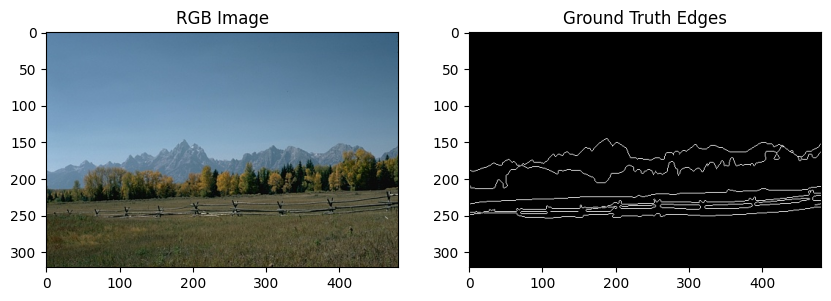

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# pick one training sample
img_path = "data/images/train/2092.jpg"
gt_path = "data/groundTruth/train/2092.mat"

# load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# load ground truth edges
mat = loadmat(gt_path)
# mat['groundTruth'] is a cell array (list of dicts)
edges_list = mat['groundTruth'][0]
# Extract the first annotator
gt_struct = edges_list[0][0, 0]  # access the MATLAB struct
# Safe access by field name
edge_map = gt_struct['Boundaries']  # binary edge mask
edge_map = edge_map.astype(np.float32)

# visualize
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("RGB Image")

plt.subplot(1,2,2)
plt.imshow(edge_map, cmap='gray')
plt.title("Ground Truth Edges")
plt.show()

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
import torch
import random
import os

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', size=(320, 320)):
        """
        root_dir: path to 'data' folder (containing images/ and groundTruth/)
        split: 'train', 'val', or 'test'
        """
        self.img_dir = os.path.join(root_dir, 'images', split)
        self.gt_dir = os.path.join(root_dir, 'groundTruth', split)
        self.size = size

        self.image_files = sorted([
            f for f in os.listdir(self.img_dir) if f.endswith('.jpg')
        ])

        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(size, interpolation=Image.BILINEAR)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        gt_path = os.path.join(self.gt_dir, img_name.replace('.jpg', '.mat'))

        # --- load RGB image
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        img = self.to_tensor(img)

        # --- load ground truth edge map
        mat = loadmat(gt_path)
        edges_list = mat['groundTruth'][0]
        gt_struct = edges_list[0][0, 0]
        edge_map = gt_struct['Boundaries']
        edge = Image.fromarray((edge_map * 255).astype('uint8')).convert('L')
        edge = self.resize(edge)
        edge = self.to_tensor(edge)
        edge = (edge > 0.2).float()  # binarize

        # --- optional flip for augmentation
        if random.random() < 0.5:
            img = torch.flip(img, dims=[2])  # horizontal
            edge = torch.flip(edge, dims=[2])

        return img, edge

torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


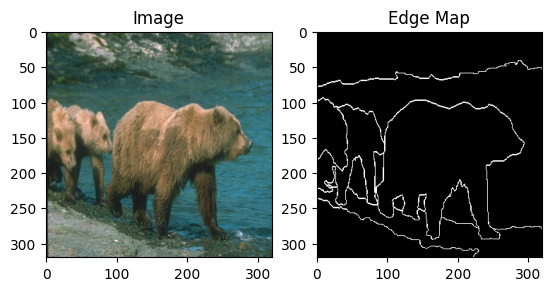

In [16]:
dataset = BSDS500Dataset(root_dir='data', split='train')
img, edge = dataset[0]
print(img.shape, edge.shape)
plt.subplot(1,2,1); plt.imshow(img.permute(1,2,0)); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(edge[0], cmap='gray'); plt.title('Edge Map')
plt.show()

In [41]:
from torch.utils.data import DataLoader
import torch.optim as optim

# --- Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 2
lr = 1e-4
epochs = 1  # for now, just test one epoch
phi = 1.0   # KL weighting

# --- DataLoader
train_dataset = BSDS500Dataset(root_dir='data', split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# --- Move models to device
model_Eh.to(device)
model_MIX.to(device)
decoder.to(device)

# --- Optimizer (we'll only train decoder + Eh for now)
params = list(model_Eh.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr)

# --- Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, (imgs, edges) in enumerate(train_loader):
        imgs, edges = imgs.to(device), edges.to(device)

        optimizer.zero_grad()

        # forward
        f_high = model_Eh(imgs)
        g_global, g_local = model_MIX(imgs)
        mu, sigma2, edge_logits = decoder(f_high[1], g_local[-1])

        # compute loss
        elbo, wce, kl = elbo_loss(mu, sigma2, edges, phi=phi)
        elbo.backward()
        optimizer.step()

        running_loss += elbo.item()

        if (i+1) % 5 == 0:
            print(f"[Epoch {epoch+1}] Step {i+1}/{len(train_loader)} - "
                  f"ELBO: {elbo.item():.4f}, WCE: {wce.item():.4f}, KL: {kl.item():.4f}")

        if i == 9:  # stop early after 10 batches
            break

    print(f"Epoch {epoch+1} done. Avg loss over 10 batches: {running_loss/10:.4f}")


RuntimeError: Given groups=1, weight of size [64, 144, 3, 3], expected input[2, 160, 160, 160] to have 144 channels, but got 160 channels instead

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MBConv(nn.Module):
    """
    Lightweight MBConv (MobileNetV2 block) for CFF fusion.
    Expansion (3x) + Depthwise Conv3x3 + Pointwise + SE (squeeze-excite, optional but paper-inspired).
    Keeps it simple: No full SE for now (add if perf lags).
    """
    def __init__(self, in_ch, out_ch, expand_ratio=3, stride=1):
        super().__init__()
        hidden_ch = int(in_ch * expand_ratio)
        self.use_res = stride == 1 and in_ch == out_ch
        # Expansion
        self.expand = nn.Conv2d(in_ch, hidden_ch, 1, bias=False) if expand_ratio > 1 else nn.Identity()
        # Depthwise
        self.dw = nn.Sequential(
            nn.Conv2d(hidden_ch, hidden_ch, 3, stride, 1, groups=hidden_ch, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True)
        )
        # Pointwise
        self.pw = nn.Sequential(
            nn.Conv2d(hidden_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.expand(x)
        x = self.dw(x)
        x = self.pw(x)
        if self.use_res:
            x += identity
        return self.relu(x)

class CFFModule(nn.Module):
    """
    Cascaded Feature Fusion (CFF): Upsample low-res, cat with high-res, fuse via MBConv.
    Matches paper: Balances effectiveness/efficiency for multi-scale decode.
    """
    def __init__(self, low_ch, high_ch, out_ch):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        fused_ch = low_ch + high_ch
        self.fuse = MBConv(fused_ch, out_ch)  # MBConv for efficient fusion

    def forward(self, low, high):
        low_up = self.upsample(low)  # Upsample low-res to high-res size
        cat = torch.cat([low_up, high], dim=1)  # Channel cat
        return self.fuse(cat)  # Fuse to out_ch, high-res

class SpatialFeatureTransform(nn.Module):
    """
    SFT block from EDTER: Modulates global + fine feats (paper: "fully modulate").
    Simple: Conv on cat, then scale/shift global with fine (affine transform).
    """
    def __init__(self, global_ch, fine_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(global_ch + fine_ch, out_ch * 2, 3, padding=1)  # Gamma + Beta for affine

    def forward(self, global_feat, fine_feat):
        cat = torch.cat([global_feat, fine_feat], dim=1)
        affine = self.conv(cat)  # [out_ch, H, W] for gamma; [out_ch, H, W] for beta
        gamma, beta = affine.chunk(2, dim=1)
        return global_feat * torch.sigmoid(gamma) + beta  # Modulate: scale + shift

class LGDDecoder(nn.Module):
    """
    Full Learnable Gaussian Decoder (LGD): Multi-scale CFF + SFT + heads.
    Inputs: f_high=[F1h,F2h] (16/32ch), global_feats=[F1g,F2g,F3g] (64/128/256),
            local_feats=[F1f,F2f,F3f] (same ch).
    Outputs: mu (1ch, full res), sigma2 (1ch, full res, >0), pa/mua/sigma2a (aux, 1ch full res).
    """
    def __init__(self, high_chs=[16, 32], global_chs=[64, 128, 256], mid_ch=64):
        super().__init__()
        self.mid_ch = mid_ch  # Fix: Store for forward scope

        # CFF for global path
        self.cff_global2 = CFFModule(global_chs[2], global_chs[1], mid_ch)
        self.cff_global1 = CFFModule(mid_ch, global_chs[0], mid_ch)

        # CFF for fine mean path
        self.cff_fmean2 = CFFModule(global_chs[2], global_chs[1], mid_ch)
        self.cff_fmean1 = CFFModule(mid_ch, global_chs[0], mid_ch)

        # CFF for fine var path
        self.cff_fvar2 = CFFModule(global_chs[2], global_chs[1], mid_ch)
        self.cff_fvar1 = CFFModule(mid_ch, global_chs[0], mid_ch)

        # Dedicated CFF for Eh fusion (low= F2h 32ch up to high= F1h 16ch -> mid_ch full res)
        self.eh_cff = CFFModule(32, 16, mid_ch)

        # Shared 1x1 conv for reducing cat(F_path + Fh_fused) from 128 -> mid_ch
        self.reduce_conv = nn.Conv2d(128, mid_ch, kernel_size=1)

        # SFT + Heads for mean (Dm)
        self.sft_mean = SpatialFeatureTransform(mid_ch, mid_ch, mid_ch)
        self.mean_head = nn.Sequential(
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1), nn.BatchNorm2d(mid_ch), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch//2, 3, padding=1), nn.BatchNorm2d(mid_ch//2), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch//2, 1, 3, padding=1)
        )

        # SFT + Heads for var (Dv): Same + SoftPlus
        self.sft_var = SpatialFeatureTransform(mid_ch, mid_ch, mid_ch)
        self.var_head = nn.Sequential(
            nn.Conv2d(mid_ch, mid_ch, 3, padding=1), nn.BatchNorm2d(mid_ch), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, mid_ch//2, 3, padding=1), nn.BatchNorm2d(mid_ch//2), nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch//2, 1, 3, padding=1),
            nn.Softplus()
        )

        # Aux heads
        self.aux_edge = nn.Conv2d(mid_ch, 1, 1)
        self.aux_mean = nn.Conv2d(mid_ch, 1, 1)
        self.aux_var = nn.Sequential(nn.Conv2d(mid_ch, 1, 1), nn.Softplus())

    def forward(self, f_high, global_feats, local_feats, training=True):
        F1h, F2h = f_high  # [B,16,H,W], [B,32,H/2,W/2]
        F1g, F2g, F3g = global_feats  # [B,64,H,W], [B,128,H/2,W/2], [B,256,H/4,W/4]
        F1f, F2f, F3f = local_feats   # Same shapes

        # 0. Fuse Eh to full-res Fh_fused (mid_ch)
        Fh_fused = self.eh_cff(F2h, F1h)  # Upsample F2h + cat F1h -> fuse [B, mid_ch, H, W]

        # 1. High-res global Fhg: Cascade, then fold Eh
        F2hg = self.cff_global2(F3g, F2g)  # [B, mid_ch, H/2, W/2]
        Fhg = self.cff_global1(F2hg, F1g)  # [B, mid_ch, H, W]
        Fhg = torch.cat([Fhg, Fh_fused], dim=1)  # [B, 2*mid_ch, H, W] — same res!
        Fhg = self.reduce_conv(Fhg)  # [B, mid_ch, H, W]

        # 2. Fine mean Ffm
        F2fm = self.cff_fmean2(F3f, F2f)  # [B, mid_ch, H/2, W/2]
        Ffm = self.cff_fmean1(F2fm, F1f)  # [B, mid_ch, H, W]
        Ffm = torch.cat([Ffm, Fh_fused], dim=1)  # [B, 2*mid_ch, H, W]
        Ffm = self.reduce_conv(Ffm)  # [B, mid_ch, H, W]

        # 3. Fine var Ffv
        F2fv = self.cff_fvar2(F3f, F2f)  # [B, mid_ch, H/2, W/2]
        Ffv = self.cff_fvar1(F2fv, F1f)  # [B, mid_ch, H, W]
        Ffv = torch.cat([Ffv, Fh_fused], dim=1)  # [B, 2*mid_ch, H, W]
        Ffv = self.reduce_conv(Ffv)  # [B, mid_ch, H, W]

        # 4-5. SFT + Heads
        modulated_mean = self.sft_mean(Fhg, Ffm)
        mu = self.mean_head(modulated_mean)
        modulated_var = self.sft_var(Fhg, Ffv)
        sigma2 = self.var_head(modulated_var)

        # 6. Aux
        pa = self.aux_edge(Fhg) if training else None
        mua = self.aux_mean(Ffm) if training else None
        sigma2a = self.aux_var(Ffv) if training else None

        return mu, sigma2, pa, mua, sigma2a

In [43]:
decoder = LGDDecoder(high_chs=[16, 32], global_chs=[64, 128, 256], mid_ch=64).to(device)
print("Decoder fixed & re-instantiated. Params:", sum(p.numel() for p in decoder.parameters()))  # ~550k now (with new modules)

Decoder fixed & re-instantiated. Params: 2254133


In [44]:
# Fake batch
B, H, W = 2, 320, 320
f_high = [
    torch.randn(B, 16, H, W).to(device),
    torch.randn(B, 32, H//2, W//2).to(device)
]
global_feats = [
    torch.randn(B, 64, H, W).to(device),
    torch.randn(B, 128, H//2, W//2).to(device),
    torch.randn(B, 256, H//4, W//4).to(device)
]
local_feats = [torch.randn_like(g) for g in global_feats]

with torch.no_grad():
    mu, sigma2, pa, mua, sigma2a = decoder(f_high, global_feats, local_feats, training=True)

print("Decoder outputs:")
print("  mu shape:", mu.shape)
print("  sigma2 shape:", sigma2.shape)
print("  pa shape:", pa.shape if pa is not None else "None")
print("  sigma2 min/max:", sigma2.min().item(), sigma2.max().item())

Decoder outputs:
  mu shape: torch.Size([2, 1, 320, 320])
  sigma2 shape: torch.Size([2, 1, 320, 320])
  pa shape: torch.Size([2, 1, 320, 320])
  sigma2 min/max: 0.1916254311800003 1.7066326141357422


In [46]:
import torch.optim as optim

# --- Optimizer: All params (Eh + encoders + decoder)
params = list(model_Eh.parameters()) + list(model.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-4, weight_decay=5e-4)  # Paper: Adam, lr=1e-4, WD=5e-4

# --- Hyperparams (paper Sec. 4.2)
epochs = 1  # Test 1 epoch; increase later
phi = 1.0   # KL weight in ELBO
lambda_pos = 1.1  # Pos sample weight for BSDS

# --- Training loop (add to your existing DataLoader setup)
model.train()
model_Eh.train()
decoder.train()
running_loss = 0.0

for epoch in range(epochs):
    for i, (imgs, edges) in enumerate(train_loader):
        imgs, edges = imgs.to(device), edges.to(device)
        optimizer.zero_grad()

        # Full forward
        f_high = model_Eh(imgs)
        global_feats, local_feats = model(imgs, training=True)  # Dropout in local
        mu, sigma2, pa, mua, sigma2a = decoder(f_high, global_feats, local_feats, training=True)

        # Main ELBO loss only (Eq.10; aux next)
        elbo_main, wce_main, kl_main = elbo_loss(mu, sigma2, edges, phi=phi, lambda_pos=lambda_pos)

        # Aux WCE on pa (global high-res, Eq.11 term 2)
        wce_aux = F.binary_cross_entropy_with_logits(pa, edges, reduction='mean') if pa is not None else 0.0

        # Aux ELBO on mua/sigma2a (fine-grained, Eq.11 term 3)
        elbo_aux, wce_aux_elbo, kl_aux = elbo_loss(mua, sigma2a, edges, phi=phi, lambda_pos=lambda_pos) if mua is not None else (0.0, 0.0, 0.0)

        # Total loss (Eq.11: main + α1 WCE_aux + α2 ELBO_aux)
        alpha1, alpha2 = 0.1, 0.4  # Paper hyperparameters
        loss = elbo_main + alpha1 * wce_aux + alpha2 * elbo_aux

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 5 == 0:
         print(f"[Epoch {epoch+1}] Batch {i+1}/{len(train_loader)} - "
               f"Total: {loss.item():.4f}, Main ELBO: {elbo_main.item():.4f}, "
               f"Aux WCE: {wce_aux.item():.4f}, Aux ELBO: {elbo_aux:.4f}")

        if i == 9:  # Stop after 10 batches for test
            break

print(f"Epoch {epoch+1} avg ELBO over 10 batches: {running_loss / 10:.4f}")

[Epoch 1] Batch 5/100 - Total: 1.1867, Main ELBO: 0.7814, Aux WCE: 0.6883, Aux ELBO: 0.8412
[Epoch 1] Batch 10/100 - Total: 1.1032, Main ELBO: 0.7305, Aux WCE: 0.6806, Aux ELBO: 0.7616
Epoch 1 avg ELBO over 10 batches: 1.1649


γ=0.5: Mean prob 0.5814, Shape torch.Size([1, 1, 320, 320])
γ=1.0: Mean prob 0.6633, Shape torch.Size([1, 1, 320, 320])
γ=2.0: Mean prob 0.7985, Shape torch.Size([1, 1, 320, 320])


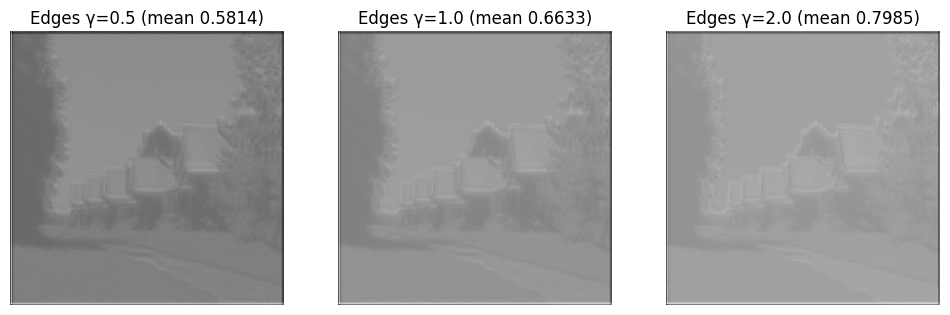

In [47]:
import matplotlib.pyplot as plt  # If not imported; for optional plot

# Inference test (eval mode, no grads)
model.eval()
model_Eh.eval()
decoder.eval()
with torch.no_grad():
    # Get 1 batch (or use next(iter(train_loader)) if loop not running)
    imgs, edges = next(iter(train_loader))  # Assumes train_loader exists
    imgs = imgs.to(device)  # First image only for simplicity
    f_high = model_Eh(imgs[:1])  # Batch 1
    global_feats, local_feats = model(imgs[:1], training=False)
    mu, sigma2, _, _, _ = decoder(f_high, global_feats, local_feats, training=False)

    # Multi-granularity sampling (Eq.14: pγ = sigmoid(μ + γ σ²))
    gamma_values = [0.5, 1.0, 2.0]  # Coarse, default, fine
    edge_maps = {}
    for gamma in gamma_values:
        p_gamma = torch.sigmoid(mu + gamma * sigma2)
        edge_maps[gamma] = p_gamma
        print(f"γ={gamma}: Mean prob {p_gamma.mean().item():.4f}, Shape {p_gamma.shape}")

# Optional: Visualize first image's edges (uncomment if matplotlib ready)
plt.figure(figsize=(12, 4))
for i, (gamma, p) in enumerate(edge_maps.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow(p[0, 0].cpu(), cmap='gray')  # First channel
    plt.title(f'Edges γ={gamma} (mean {p.mean().item():.4f})')
    plt.axis('off')
plt.show()